In [1]:
import json
import dotenv

In [18]:
import langchain_openai

In [16]:
from langchain_openai import ChatOpenAI
from langchain_huggingface import HuggingFaceEmbeddings

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from dialogue2graph import metrics
from dialogue2graph.pipelines.core.graph import Graph
from dialogue2graph.pipelines.model_storage import ModelStorage
from dialogue2graph.pipelines.helpers.parse_data import PipelineRawDataType

/home/peshkichev/miniconda3/envs/py311/lib/python3.11/site-packages/pydantic/_internal/_fields.py:198: UserWarning: Field name "validate" in "Dialogue" shadows an attribute in parent "BaseModel"
  warnings.warn(
2025-04-18 10:45:19,875 - datasets - INFO - PyTorch version 2.6.0 available.


In [5]:
dotenv.load_dotenv()

True

In [6]:
ms = ModelStorage()

In [ ]:
ms.add(
    key="grouping_llm",
    config={"model_name": "chatgpt-4o-latest", "temperature": 0},
    model_type=ChatOpenAI,
)
ms.add(
    key="extending_llm",
    config={"model_name": "chatgpt-4o-latest", "temperature": 0},
    model_type=ChatOpenAI,
)
ms.add(
    key="filling_llm",
    config={"model_name": "o3-mini", "temperature": 1},
    model_type=ChatOpenAI,
)
ms.add(
    key="formatting_llm",
    config={"model_name": "gpt-4o-mini", "temperature": 0},
    model_type=ChatOpenAI,
)
ms.add(
    key="sim_model",
    config={"model_name": "BAAI/bge-m3", "model_kwargs": {"device": "cuda:0"}},
    model_type=HuggingFaceEmbeddings,
)

In [25]:
from dialogue2graph.datasets.complex_dialogues import generation

In [20]:
ms.save("model_storage.yml")

2025-04-18 11:20:01,489 - /data/home/peshkichev/projects/chatsky-llm-autoconfig/dialogue2graph/pipelines/model_storage.py - INFO - Saved 5 models to model_storage.yml


In [21]:
ms.load("model_storage.yml")

2025-04-18 11:20:07,169 - /data/home/peshkichev/projects/chatsky-llm-autoconfig/dialogue2graph/pipelines/model_storage.py - INFO - Successfully loaded 5 models from model_storage.yml


In [29]:
sampler = generation.RecursiveDialogueSampler()

In [27]:
with open("transfer_2.json") as f:
    data = json.load(f)

In [ ]:
sampler.invoke(Graph(data["true_graph"]), ms.storage["grouping_llm"].model, 15)

In [27]:
ms

ModelStorage(storage={'grouping_llm': StoredData(key='grouping_llm', config={'model_name': 'chatgpt-4o-latest', 'temperature': 0}, model_type=<class 'langchain_openai.chat_models.base.ChatOpenAI'>, model=ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x7f14f55caa10>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x7f146e49a890>, root_client=<openai.OpenAI object at 0x7f14fdab5dd0>, root_async_client=<openai.AsyncOpenAI object at 0x7f14f55c9c90>, model_name='chatgpt-4o-latest', temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********'))), 'extending_llm': StoredData(key='extending_llm', config={'model_name': 'chatgpt-4o-latest', 'temperature': 0}, model_type=<class 'langchain_openai.chat_models.base.ChatOpenAI'>, model=ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x7f14f55c0e10>, async_client=<openai.resources.chat.completions.completions.AsyncCompleti

### D2G Light pipeline

In [23]:
from dialogue2graph.pipelines.d2g_light.pipeline import D2GLightPipeline

pipeline = D2GLightPipeline(
    name="d2g_light",
    model_storage=ms,
    filling_llm="filling_llm",
    formatting_llm="formatting_llm",
    sim_model="sim_model",
    step2_evals=metrics.DGEvalBase,
    end_evals=metrics.DGEvalBase,
)

In [ ]:
data = [
    {"text": "Hey there! How can I help you today?", "participant": "assistant"},
    {"text": "I need to book a ride to the airport.", "participant": "user"},
    {
        "text": "Sure! I can help with that. When is your flight, and where are you departing from?",
        "participant": "assistant",
    },
    {"text": "Do you have any other options?", "participant": "user"},
    {
        "text": "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
        "participant": "assistant",
    },
    {"text": "No, I'll manage on my own.", "participant": "user"},
    {"text": "No worries! Feel free to reach out anytime.", "participant": "assistant"},
    {"text": "Alright, thanks anyway.", "participant": "user"},
    {"text": "You're welcome! Have a fantastic trip!", "participant": "assistant"},
]
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [ ]:
graph.graph_dict

In [ ]:
data = [
    [
        {"text": "Hey there! How can I help you today?", "participant": "assistant"},
        {"text": "I need to book a ride to the airport.", "participant": "user"},
        {
            "text": "Sure! I can help with that. When is your flight, and where are you departing from?",
            "participant": "assistant",
        },
        {"text": "Do you have any other options?", "participant": "user"},
        {
            "text": "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
            "participant": "assistant",
        },
        {"text": "Actually, never mind.", "participant": "user"},
        {
            "text": "Alright, let me know if you need help later. Have a great day!",
            "participant": "assistant",
        },
        {"text": "Okay, have a great day!", "participant": "user"},
        {"text": "Glad to help! Safe travels.", "participant": "assistant"},
    ],
    [
        {"text": "Hey there! How can I help you today?", "participant": "assistant"},
        {"text": "I need to book a ride to the airport.", "participant": "user"},
        {
            "text": "Sure! I can help with that. When is your flight, and where are you departing from?",
            "participant": "assistant",
        },
        {"text": "Do you have any other options?", "participant": "user"},
        {
            "text": "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
            "participant": "assistant",
        },
        {"text": "No, I'll manage on my own.", "participant": "user"},
        {
            "text": "No worries! Feel free to reach out anytime.",
            "participant": "assistant",
        },
        {"text": "Alright, thanks anyway.", "participant": "user"},
        {"text": "You're welcome! Have a fantastic trip!", "participant": "assistant"},
    ],
]
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [ ]:
graph.graph_dict

In [ ]:
data = [
    {
        "messages": [
            {
                "text": "Hey there! How can I help you today?",
                "participant": "assistant",
            },
            {"text": "I need to book a ride to the airport.", "participant": "user"},
            {
                "text": "Sure! I can help with that. When is your flight, and where are you departing from?",
                "participant": "assistant",
            },
            {"text": "Do you have any other options?", "participant": "user"},
            {
                "text": "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
                "participant": "assistant",
            },
            {"text": "No, I'll manage on my own.", "participant": "user"},
            {
                "text": "No worries! Feel free to reach out anytime.",
                "participant": "assistant",
            },
            {"text": "Alright, thanks anyway.", "participant": "user"},
            {
                "text": "You're welcome! Have a fantastic trip!",
                "participant": "assistant",
            },
        ]
    }
]
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [ ]:
data

In [ ]:
graph.graph_dict

In [ ]:
gr = Graph(data["true_graph"])
gr.graph_dict

In [47]:
report

PipelineReport(service='d2g_light', properties={'time': 2.1800806522369385, 'simple_graph_comparison': True}, subreports=[{}])

In [ ]:
graph.graph_dict

In [ ]:
with open("transfer_2.json") as f:
    data = json.load(f)

raw_data = PipelineRawDataType(dialogs=data["dialogs"])
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [24]:
report

PipelineReport(service='d2g_light', properties={'time': 37.24576377868652, 'simple_graph_comparison': True}, subreports=[{}])

In [ ]:
with open("transfer_2.json") as f:
    data = json.load(f)

raw_data = PipelineRawDataType(dialogs=data["dialogs"], true_graph=data["true_graph"])
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [36]:
report

PipelineReport(service='d2g_light', properties={'time': 35.30027651786804, 'simple_graph_comparison': False}, subreports=[{}])

In [ ]:
raw_data = PipelineRawDataType(dialogs="transfer_2.json", true_graph="transfer_2.json")
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [24]:
report

PipelineReport(service='d2g_light', properties={'time': 37.24576377868652, 'simple_graph_comparison': True}, subreports=[{}])

In [ ]:
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [ ]:
with open("test_graph_1.json", encoding="utf-8") as f:
    data = json.load(f)
Graph(data["true_graph"]).visualise_short(
    "Fixing a calendar sync delay with time zones"
)

In [ ]:
raw_data = PipelineRawDataType(dialogs="test_graph_1.json")
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("Fixing a calendar sync delay with time zones")

In [ ]:
raw_data = PipelineRawDataType(dialogs=data["dialogs"], true_graph=data["true_graph"])
graph, report = pipeline.invoke(raw_data, enable_evals=True)
report

### D2G LLM pipeline

In [64]:
from dialogue2graph.pipelines.d2g_llm.pipeline import D2GLLMPipeline

pipeline = D2GLLMPipeline(
    name="d2g_llm",
    model_storage=ms,
    grouping_llm="grouping_llm",
    filling_llm="filling_llm",
    formatting_llm="formatting_llm",
    sim_model="sim_model",
    step2_evals=metrics.DGEvalBase,
    end_evals=metrics.DGEvalBase,
)

In [ ]:
raw_data = PipelineRawDataType(dialogs="transfer.json")
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [ ]:
data = [
    {"text": "Hey there! How can I help you today?", "participant": "assistant"},
    {"text": "I need to book a ride to the airport.", "participant": "user"},
    {
        "text": "Sure! I can help with that. When is your flight, and where are you departing from?",
        "participant": "assistant",
    },
    {"text": "Do you have any other options?", "participant": "user"},
    {
        "text": "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
        "participant": "assistant",
    },
    {"text": "No, I'll manage on my own.", "participant": "user"},
    {"text": "No worries! Feel free to reach out anytime.", "participant": "assistant"},
    {"text": "Alright, thanks anyway.", "participant": "user"},
    {"text": "You're welcome! Have a fantastic trip!", "participant": "assistant"},
]
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [ ]:
data = [
    [
        {"text": "Hey there! How can I help you today?", "participant": "assistant"},
        {"text": "I need to book a ride to the airport.", "participant": "user"},
        {
            "text": "Sure! I can help with that. When is your flight, and where are you departing from?",
            "participant": "assistant",
        },
        {"text": "Do you have any other options?", "participant": "user"},
        {
            "text": "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
            "participant": "assistant",
        },
        {"text": "Actually, never mind.", "participant": "user"},
        {
            "text": "Alright, let me know if you need help later. Have a great day!",
            "participant": "assistant",
        },
        {"text": "Okay, have a great day!", "participant": "user"},
        {"text": "Glad to help! Safe travels.", "participant": "assistant"},
    ],
    [
        {"text": "Hey there! How can I help you today?", "participant": "assistant"},
        {"text": "I need to book a ride to the airport.", "participant": "user"},
        {
            "text": "Sure! I can help with that. When is your flight, and where are you departing from?",
            "participant": "assistant",
        },
        {"text": "Do you have any other options?", "participant": "user"},
        {
            "text": "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
            "participant": "assistant",
        },
        {"text": "No, I'll manage on my own.", "participant": "user"},
        {
            "text": "No worries! Feel free to reach out anytime.",
            "participant": "assistant",
        },
        {"text": "Alright, thanks anyway.", "participant": "user"},
        {"text": "You're welcome! Have a fantastic trip!", "participant": "assistant"},
    ],
]
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [ ]:
data = [
    {
        "messages": [
            {
                "text": "Hey there! How can I help you today?",
                "participant": "assistant",
            },
            {"text": "I need to book a ride to the airport.", "participant": "user"},
            {
                "text": "Sure! I can help with that. When is your flight, and where are you departing from?",
                "participant": "assistant",
            },
            {"text": "Do you have any other options?", "participant": "user"},
            {
                "text": "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
                "participant": "assistant",
            },
            {"text": "No, I'll manage on my own.", "participant": "user"},
            {
                "text": "No worries! Feel free to reach out anytime.",
                "participant": "assistant",
            },
            {"text": "Alright, thanks anyway.", "participant": "user"},
            {
                "text": "You're welcome! Have a fantastic trip!",
                "participant": "assistant",
            },
        ]
    }
]
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [ ]:
with open("transfer.json") as f:
    data = json.load(f)
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [ ]:
with open("test_graph_1.json", encoding="utf-8") as f:
    data = json.load(f)
raw_data = PipelineRawDataType(dialogs=data["dialogs"], true_graph=data["true_graph"])
graph, report = pipeline.invoke(raw_data, enable_evals=True)
report

### D2G LLM extender

In [8]:
from dialogue2graph.pipelines.d2g_extender.pipeline import D2GExtenderPipeline

pipeline = D2GExtenderPipeline(
    name="d2g_ext",
    model_storage=ms,
    extending_llm="filling_llm",
    filling_llm="filling_llm",
    formatting_llm="formatting_llm",
    sim_model="sim_model",
    step1_evals=metrics.PreDGEvalBase,
    extender_evals=metrics.PreDGEvalBase,
    step2_evals=metrics.DGEvalBase,
    end_evals=metrics.DGEvalBase,
)

2025-04-17 17:28:57,546 - /data/home/peshkichev/projects/chatsky-llm-autoconfig/dialogue2graph/pipelines/model_storage.py - WARNING - Key 'filling_llm' already exists in storage. Overwriting.
2025-04-17 17:28:57,546 - /data/home/peshkichev/projects/chatsky-llm-autoconfig/dialogue2graph/pipelines/model_storage.py - WARNING - Key 'filling_llm' already exists in storage. Overwriting.
2025-04-17 17:28:57,547 - /data/home/peshkichev/projects/chatsky-llm-autoconfig/dialogue2graph/pipelines/model_storage.py - WARNING - Key 'formatting_llm' already exists in storage. Overwriting.


FIELDS: <class 'langchain_openai.chat_models.base.ChatOpenAI'>


2025-04-17 17:28:57,631 - /data/home/peshkichev/projects/chatsky-llm-autoconfig/dialogue2graph/pipelines/model_storage.py - INFO - Added <class 'langchain_openai.chat_models.base.ChatOpenAI'> model 'd2g_extender_dialog_llm:v1' to storage
2025-04-17 17:28:57,632 - /data/home/peshkichev/projects/chatsky-llm-autoconfig/dialogue2graph/pipelines/model_storage.py - WARNING - Key 'sim_model' already exists in storage. Overwriting.


In [ ]:
data = [
    {"text": "Hey there! How can I help you today?", "participant": "assistant"},
    {"text": "I need to book a ride to the airport.", "participant": "user"},
    {
        "text": "Sure! I can help with that. When is your flight, and where are you departing from?",
        "participant": "assistant",
    },
    {"text": "Do you have any other options?", "participant": "user"},
    {
        "text": "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
        "participant": "assistant",
    },
    {"text": "No, I'll manage on my own.", "participant": "user"},
    {"text": "No worries! Feel free to reach out anytime.", "participant": "assistant"},
    {"text": "Alright, thanks anyway.", "participant": "user"},
    {"text": "You're welcome! Have a fantastic trip!", "participant": "assistant"},
]
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [ ]:
data = [
    [
        {"text": "Hey there! How can I help you today?", "participant": "assistant"},
        {"text": "I need to book a ride to the airport.", "participant": "user"},
        {
            "text": "Sure! I can help with that. When is your flight, and where are you departing from?",
            "participant": "assistant",
        },
        {"text": "Do you have any other options?", "participant": "user"},
        {
            "text": "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
            "participant": "assistant",
        },
        {"text": "Actually, never mind.", "participant": "user"},
        {
            "text": "Alright, let me know if you need help later. Have a great day!",
            "participant": "assistant",
        },
        {"text": "Okay, have a great day!", "participant": "user"},
        {"text": "Glad to help! Safe travels.", "participant": "assistant"},
    ]
]
raw_data = PipelineRawDataType(dialogs=data, supported_graph=graph.graph_dict)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [ ]:
data = [
    {
        "messages": [
            {
                "text": "Hey there! How can I help you today?",
                "participant": "assistant",
            },
            {"text": "I need to book a ride to the airport.", "participant": "user"},
            {
                "text": "Sure! I can help with that. When is your flight, and where are you departing from?",
                "participant": "assistant",
            },
            {"text": "Do you have any other options?", "participant": "user"},
            {
                "text": "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
                "participant": "assistant",
            },
            {"text": "No, I'll manage on my own.", "participant": "user"},
            {
                "text": "No worries! Feel free to reach out anytime.",
                "participant": "assistant",
            },
            {"text": "Alright, thanks anyway.", "participant": "user"},
            {
                "text": "You're welcome! Have a fantastic trip!",
                "participant": "assistant",
            },
        ]
    }
]
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [ ]:
Graph(data["true_graph"]).graph_dict

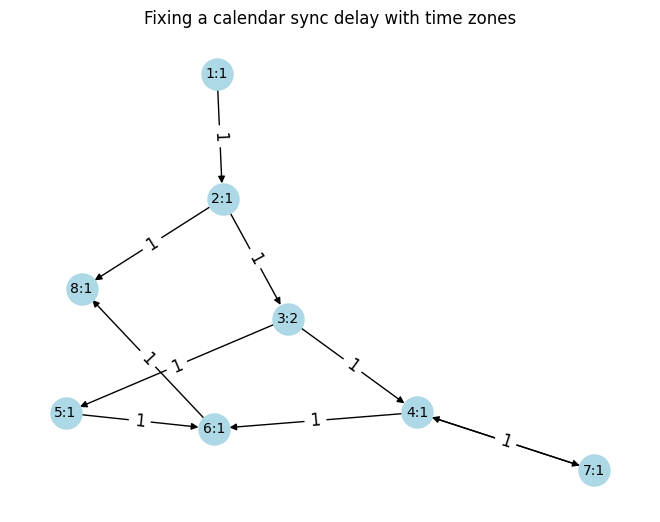

In [9]:
with open("test_graph_1.json", encoding="utf-8") as f:
    data = json.load(f)
Graph(data["true_graph"]).visualise_short(
    "Fixing a calendar sync delay with time zones"
)

In [ ]:
raw_data = PipelineRawDataType(dialogs=data["dialogs"], true_graph=data["true_graph"])
graph, report = pipeline.invoke(raw_data, enable_evals=True)
report

In [ ]:
graph.graph_dict

In [ ]:
graph.visualise_short("Fixing a calendar sync delay with time zones")

In [10]:
with open("test_metrics_data.json", encoding="utf-8") as f:
    data_2 = json.load(f)

In [12]:
data_2[2]

{'graph': {'edges': [{'source': 2,
    'target': 3,
    'utterances': ["Yes, I checked but it still doesn't sync."]},
   {'source': 3,
    'target': 4,
    'utterances': ['Alright, please guide me through the steps.']},
   {'source': 4,
    'target': 6,
    'utterances': ["I've followed the steps and it seems to be working now."]},
   {'source': 2,
    'target': 8,
    'utterances': ["I think I'll handle it later. Thanks anyway."]},
   {'source': 4,
    'target': 7,
    'utterances': ['I want to change the time zone instead.']},
   {'source': 7,
    'target': 4,
    'utterances': ["Sure, let's adjust the time zone settings."]},
   {'source': 5,
    'target': 6,
    'utterances': ["After adjusting, it still doesn't sync."]},
   {'source': 3,
    'target': 5,
    'utterances': ['Time zone settings are correct, but the issue persists.']},
   {'source': 6,
    'target': 8,
    'utterances': ["Actually, it's still not syncing. I want to try something else."]}],
  'nodes': [{'id': 2,
    'la

In [ ]:
raw_data = PipelineRawDataType(
    dialogs=data_2[2]["dialogues"], true_graph=data["true_graph"]
)
graph, report = pipeline.invoke(raw_data, enable_evals=True)
report

In [13]:
raw_data = PipelineRawDataType(
    dialogs=data_2[2]["dialogues"], true_graph=data_2[2]["graph"]
)
graph, report = pipeline.invoke(raw_data, enable_evals=True)
report

2025-04-17 17:32:58,210 - chromadb.telemetry.product.posthog - INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


2025-04-17 17:33:31,596 - httpx - INFO - HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-17 17:33:53,078 - httpx - INFO - HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-17 17:33:53,134 - dialogue2graph.metrics.no_llm_metrics.metrics - INFO - Graph has all the dialogues
2025-04-17 17:34:07,971 - httpx - INFO - HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-17 17:34:07,991 - dialogue2graph.metrics.no_llm_metrics.metrics - INFO - Graph has all the dialogues
2025-04-17 17:34:09,875 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: BAAI/bge-m3


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-17 17:35:04,112 - httpx - INFO - HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-17 17:35:04,461 - dialogue2graph.metrics.no_llm_metrics.metrics - INFO - Graph has all the dialogues


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PipelineReport(service='d2g_ext', properties={'time': 126.26458096504211, 'simple_graph_comparison': False, 'complex_graph_comparison': {'value': False, 'description': 'At least one of nodes corresponds to more than one in another graph'}}, subreports=[{'d2g_light:compare_graphs:step2': {'value': False, 'description': 'Numbers of nodes do not match: 6 != 7'}, 'd2g_light:is_same_structure:step2': False, 'd2g_light:compare_graphs:end': {'value': False, 'description': 'Numbers of nodes do not match: 6 != 7'}, 'd2g_light:is_same_structure:end': False, 'is_same_structure:step1': False, 'is_same_structure:extender': False, 'compare_graphs:step2': {'value': False, 'description': 'At least one of nodes corresponds to more than one in another graph'}, 'is_same_structure:step2': False, 'compare_graphs:end': {'value': False, 'description': 'At least one of nodes corresponds to more than one in another graph'}, 'is_same_structure:end': False}])